# Retail pricing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#import scipy


import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys, json

from sklearn.preprocessing import  StandardScaler , OneHotEncoder 
\
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split #
# from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier

from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, roc_auc_score, f1_score, median_absolute_error, PredictionErrorDisplay

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
 
#from models.models import ModelSequential

#import optuna
import pickle

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

#!pip freeze > requirements.txt

In [3]:
from utils.config_reader import config_reader
from utils.functions import get_ROC_plot,  get_comparison, annotate_scatterplot
#from utils.models_utils import f1, callbacks


# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

## Read files

In [424]:
# df = pd.read_csv('../data/accepted_2007_to_2018Q4.csv.gz')
# # df

# sample = df.sample(n=100000 , axis=0, random_state=random_seed)
# #display(sample)
# sample.to_csv('../data/sample_all_features.zip') 

In [5]:
# Reading the sample of 100,000 entries
data = pd.read_csv(config.data_dir + 'retail_price.zip')
data.head()

,product_id,product_category_name,month_year,qty,...,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,...,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,...,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,...,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,...,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,...,45.95,4.0,15.100000,45.95


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

In [426]:
# data_orig.drop(['Unnamed: 0'], axis=1, inplace=True)'member_id'
# data_orig.isna().sum().value_counts()

# 1. EDA

### Loan_status (target feature)

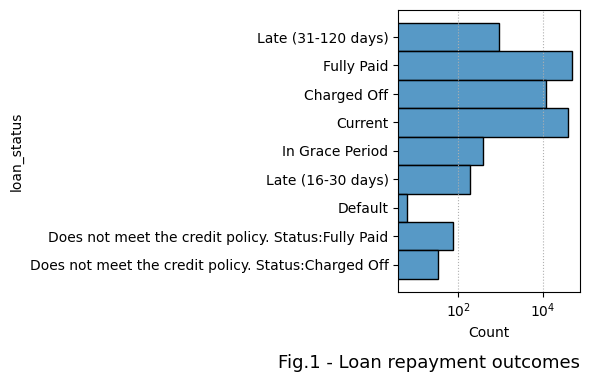

In [435]:
fig, ax = plt.subplots(figsize=(6, 4))
fig = sns.histplot(data, y='loan_status')
fig.set_title('Fig.1 -  ', y=-0.3, fontsize=13, loc='right')
ax.set_xscale('log')

plt.tight_layout()
ax.xaxis.grid(linestyle=':')
plot_counter=1
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

To simplify the task let us exclude customers who either do not meet the credit policy or who are in the grace period.

In [436]:
data['loan_status'].value_counts(True)

Fully Paid                                             0.47896
Current                                                0.38550
Charged Off                                            0.11940
Late (31-120 days)                                     0.00927
In Grace Period                                        0.00379
Late (16-30 days)                                      0.00193
Does not meet the credit policy. Status:Fully Paid     0.00075
Does not meet the credit policy. Status:Charged Off    0.00034
Default                                                0.00006
Name: loan_status, dtype: float64

## Missing values

In [109]:
X.isna().sum().value_counts(ascending=False)

0    64
dtype: int64

In [110]:
cols_null_percent = X.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null.head())

imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# check if nan are present in the dataset
for i in X.columns:
    assert X[i].isna().sum()== 0
    
X.columns.shape

Series([], dtype: float64)

(64,)

### Target feature

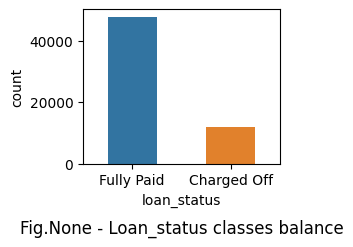

In [111]:
fig_id = None

fig, ax = plt.subplots(figsize=(3, 3)) 
sns.countplot(data=data_copy, x='loan_status', width=0.5)
ax.set_title(f'Fig.{fig_id} - Loan_status classes balance', y=-0.5)
plt.tight_layout();

#plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

#print(targets['Sales_CLoans'].value_counts(True).round(2))

In [112]:
# encoding
y = y.apply(lambda x: 1 if x=='Fully Paid' else 0)

unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [11940 47896]


In [113]:
X_copy, y_copy = X.copy(), y.copy()

### balancing classes

In [114]:
# Synthetic resampling of minority class
sm = SMOTE(random_state=random_seed)
X_copy, y_copy = sm.fit_resample(X_copy, y_copy)

unique, counts = np.unique(y_copy, return_counts=True)
print('After synthetic resampling : ',unique, counts)

After synthetic resampling :  [0 1] [47896 47896]


# 2. Modelling

In [115]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_copy, y_copy, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (76633, 64)
Test shape:  (9579, 64)
Valid shape: (9580, 64)


In [116]:
models_dict = dict()

### Random forest

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      4878
           1       0.70      0.69      0.70      4701

    accuracy                           0.71      9579
   macro avg       0.71      0.71      0.71      9579
weighted avg       0.71      0.71      0.71      9579

roc_auc:  0.778


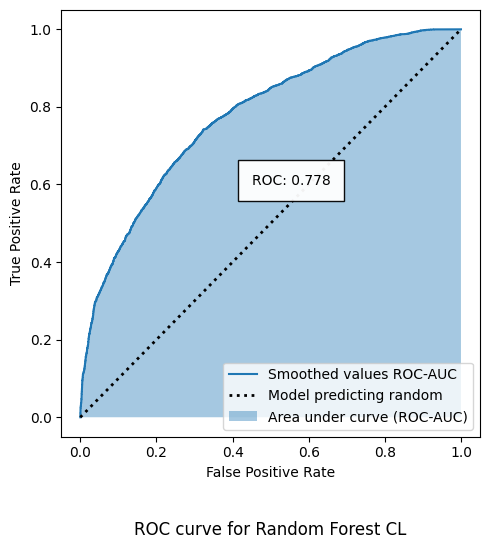

In [117]:
rf = RandomForestClassifier(
    n_estimators=110, 
    min_samples_leaf=5,
    max_depth=7,
    #verbose=1, 
    n_jobs=-1, 
    random_state=random_seed)

#Train model
rf.fit(X_train, y_train)

# Prediction
y_pred = rf.predict(X_test)

# Save results
models_dict.update({'random_forest':rf})

print(classification_report(y_test, y_pred))

get_ROC_plot(rf, X_test, y_test, 'Random Forest CL')

### Gradient boosting

In [118]:
# gb = GradientBoostingClassifier(
#     learning_rate=0.01,
#     n_estimators=95,
#     min_samples_leaf=3,
#     max_depth=3,
#     random_state=random_seed
# )

# # train model
# gb.fit(X_train, y_train)
 
# # Predict target values
# y_pred = gb.predict(X_test)

# # Metrics report
# print(classification_report(y_test, y_pred))

# # Save results
# models_dict.update({'gradient_boosting':gb})

# get_ROC_plot(gb, X_test, y_test, 'Gradient Boosting CL')

In [119]:
# from sklearn.metrics import confusion_matrix 
# print(confusion_matrix(y_test, y_pred))

## Models Comparison

In [120]:
# # Save model to the given path in the pkl format
# model_name = 'gbr_cl'
# full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
# #models_dict.update({'Revenue_CLoans':model_name})

# with open(full_path, 'wb') as f:
#     pickle.dump(gbr_cl, f)

## Other

### Gradient boosting + Optuna

In [121]:
def optuna_gb(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 300, 350, 1)
    max_depth = trial.suggest_int('max_depth', 5, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_test)[:,1])
    F1_score = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    
    return F1_score, roc_score

#%%time
sampler = TPESampler(seed=random_seed) # fix random seed

# create study set
study = optuna.create_study(study_name="GBClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=5)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

In [122]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 1
Trial with highest accuracy: 
	params: {'n_estimators': 319, 'max_depth': 10, 'min_samples_leaf': 4, 'learning_rate': 0.0638792635777333}


              precision    recall  f1-score   support

           0       0.95      0.77      0.85      4878
           1       0.80      0.95      0.87      4701

    accuracy                           0.86      9579
   macro avg       0.87      0.86      0.86      9579
weighted avg       0.88      0.86      0.86      9579

roc_auc:  0.922


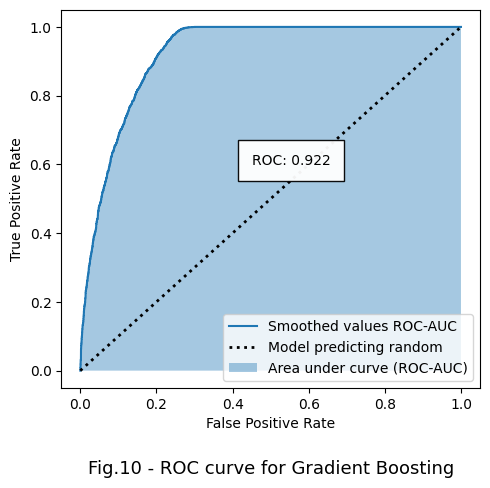

In [123]:
# Apply best parameters
gb_opt_cl = GradientBoostingClassifier(**best_hyperparameters.params, random_state=random_seed) #study.best_params
gb_opt_cl.fit(X_train, y_train)

# Predict target values
y_pred_gb_optu = gb_opt_cl.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb_optu))

# Save results
models_dict.update({'g_boosting_opt':gb_opt_cl})

get_ROC_plot(gb_opt_cl, X_test, y_test, 'Gradient Boosting', plot_counter=10)  # + Optuna for CL

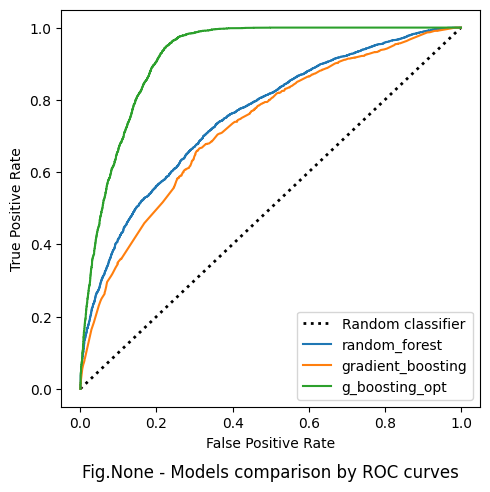

In [ ]:
get_comparison(models_dict, X_test, y_test)

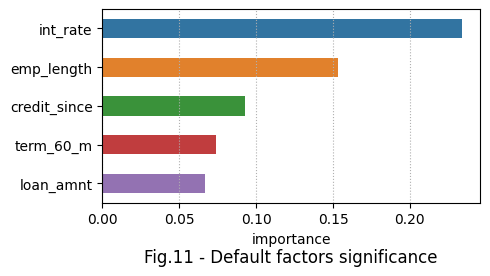

In [124]:
factors = pd.DataFrame({'importance':gb_opt_cl.feature_importances_}, index=X_train.columns).sort_values(by='importance', ascending=False).iloc[:5]

plot_counter=11

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='importance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Default factors significance', y=-0.35); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

# 3. Interest rate modelling

### Check for multicollinearity

In [125]:
X, y = data_copy.drop(['int_rate','loan_status', 'sub_grade'], axis=1), np.log(data_copy['int_rate'])  #, , np.log(data['int_rate'] # 'grade'

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in X.columns if X[s].dtypes in numerics]
сat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']
num_features

transformed_features = X.columns
transformed_features

Index(['loan_amnt', 'term', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc_log', 'purpose', 'pub_rec_bankruptcies', 'credit_since',
       'source_verified', 'income_verified', 'pub_rec'],
      dtype='object')

In [126]:
transformer1 = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse=False,drop='if_binary'), сat_features), remainder = 'passthrough') 

transformer1 = transformer1.fit(X)
results = transformer1.transform(X)

results = pd.DataFrame(results, columns=transformer1.transformers_[0][1].get_feature_names_out().tolist() + transformer1.transformers_[1][1].get_feature_names_out().tolist())

# save columns for later usage
imputer_columns = results.columns

In [127]:
# check for missing values
imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(results), columns=imputer_columns)

# check if nan are present in the dataset
for i in X.columns:
    assert X[i].isna().sum()== 0

### Check for multicollinearity

In [128]:
# select features with correlation coefficient > 0.7
pivot = X.corr()

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Features with high correlation coef:')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Features with high correlation coef:
1 home_ownership_MORTGAGE
2 home_ownership_RENT
3 pub_rec_bankruptcies_1
4 pub_rec_1


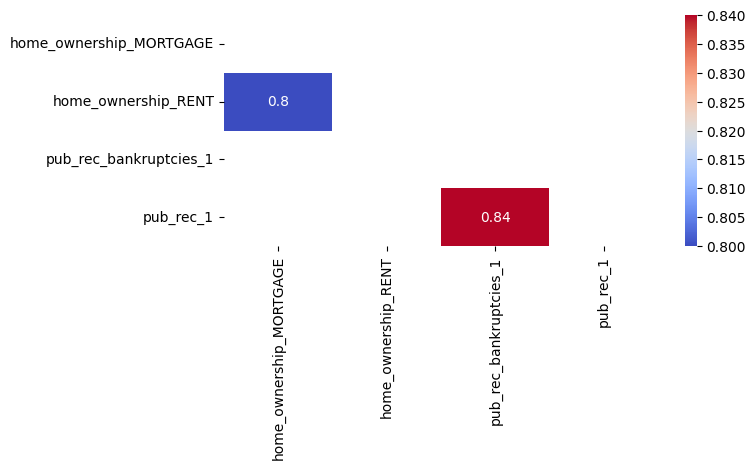

In [129]:
# heatmap
fig = plt.figure(figsize=(7, 3))
matrix = np.triu(pivot)
sns.heatmap(round(abs(pivot), 2), annot=True, cmap= 'coolwarm', mask=matrix);

In [130]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (47868, 28)
Test shape:  (5984, 28)
Valid shape: (5984, 28)


In [131]:
X.head(2)

,loan_amnt,emp_length,annual_inc_log,credit_since,...,pub_rec_bankruptcies_1,source_verified_1,income_verified_1,pub_rec_1
0,0.649080,1.134998,2.348576,4.737288,...,0.0,0.0,0.0,0.0
1,-0.677496,1.134998,0.257095,0.625482,...,0.0,1.0,1.0,0.0


## Linear models

In [132]:
# # Creation an instance
# lin_cl = LinearRegression()

# # Train the Model
# lin_cl.fit(X_train, y_train)

# # Predict target values
# y_pred_lin = lin_cl.predict(X_test)

# print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
# print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

### Linear regression with Stochastic gradient descent

In [133]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Creation an instance
lin_sgd = linear_model.SGDRegressor(random_state=random_seed)

# Train the Model
lin_sgd.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = lin_sgd.predict(X_train), lin_sgd.predict(X_test)
 

print(f'MSE: {round(mean_squared_error(y_test, y_pred_test),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_test)*100,2)} %')

print("Train R^2: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_pred_test)))

MSE: 0.1
MAPE: 10.46 %
Train R^2: 0.246
Test R^2: 0.258


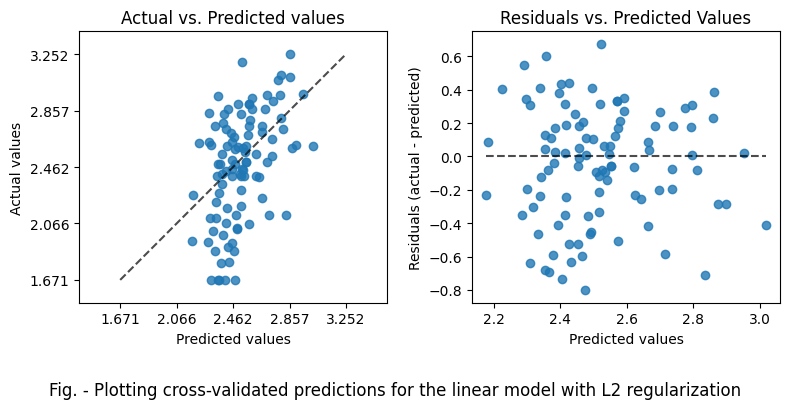

In [134]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions for the linear model with L2 regularization", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');


In [135]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': lin_sgd.coef_}, index=X_train.columns)
coef_df
# add the intercept coefficient
coef_df.loc['INTERCEPT'] = lin_sgd.intercept_
display(coef_df.sort_values('Coefficients',ascending=False))

,Coefficients
INTERCEPT,1.514019
home_ownership_RENT,0.516305
home_ownership_OWN,0.486766
home_ownership_MORTGAGE,0.451484
...,...
purpose_education,0.003199
pub_rec_bankruptcies_1,0.001082
credit_since,-0.050871
annual_inc_log,-0.051182


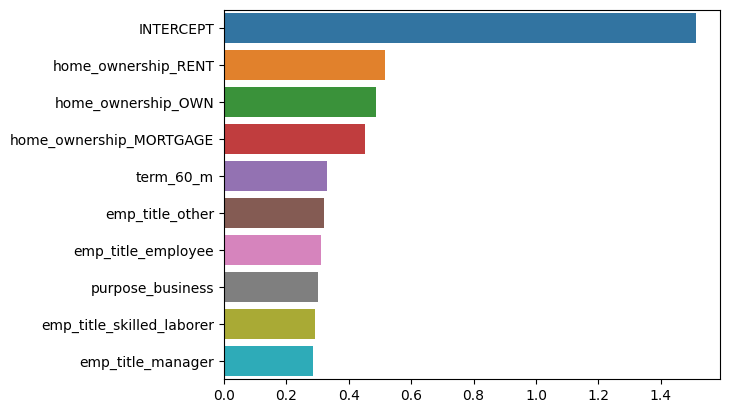

In [136]:
temp = coef_df.sort_values('Coefficients',ascending=False)
sns.barplot(x=temp.values.flatten()[:10], y=temp.index[:10])
plt.show()

> The variance of the model is not constant across various levels of the predicted variable. It means that the model fails to predict low and high interst rates.

### Regularization

In [137]:
# Creation an instance
lasso_lr_poly = linear_model.Lasso(alpha=0.005, random_state=random_seed)

# Train the Model
lasso_lr_poly.fit(X_train, y_train)

# Predict target values
y_pred_lin = lasso_lr_poly.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

MSE: 0.1
MAPE: 10.55 %


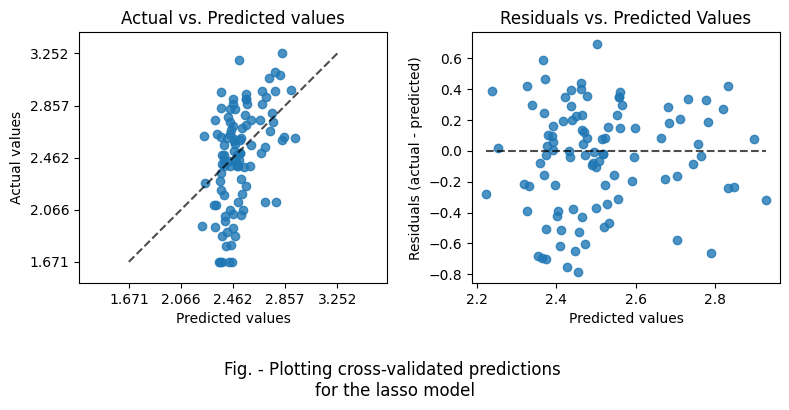

In [138]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions \nfor the lasso model", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

### Polynomial

In [139]:
from sklearn.preprocessing import PolynomialFeatures
# Creation an instance
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)

# Generation of polynomial features for samples
X_train_poly, X_test_poly, X_valid_poly = poly.transform(X_train), poly.transform(X_test), poly.transform(X_valid)


#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)


(47868, 434)
(5984, 434)


In [140]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Creation an instance
lin_poly = linear_model.SGDRegressor(random_state=random_seed)

# Train the Model
lin_poly.fit(X_train, y_train)

# Predict target values
y_train_pred_poly, y_test_pred_poly = lin_poly.predict(X_train), lin_poly.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_test_pred_poly),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_test_pred_poly)*100,2)} %')

# print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_pred_poly)))
# print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_pred_poly)))

MSE: 0.1
MAPE: 10.46 %


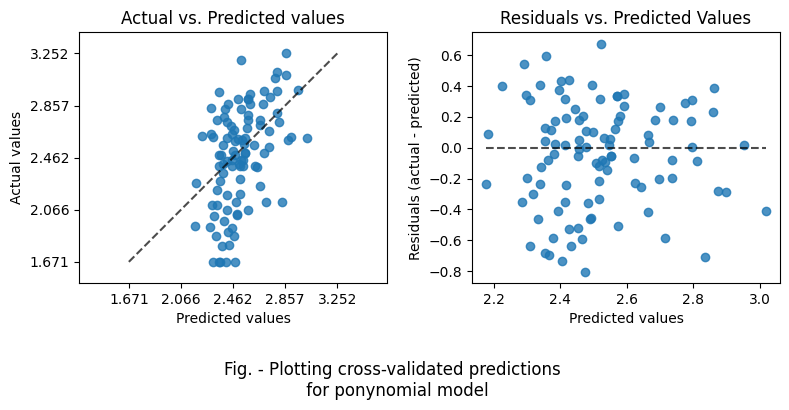

In [141]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred_poly,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred_poly,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions \n for ponynomial model", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

In [142]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': lin_poly.coef_}, index=X_train.columns)
coef_df
# add the intercept coefficient
coef_df.loc['INTERCEPT'] = lin_poly.intercept_
display(coef_df.sort_values('Coefficients',ascending=False))

,Coefficients
INTERCEPT,1.514019
home_ownership_RENT,0.516305
home_ownership_OWN,0.486766
home_ownership_MORTGAGE,0.451484
...,...
purpose_education,0.003199
pub_rec_bankruptcies_1,0.001082
credit_since,-0.050871
annual_inc_log,-0.051182


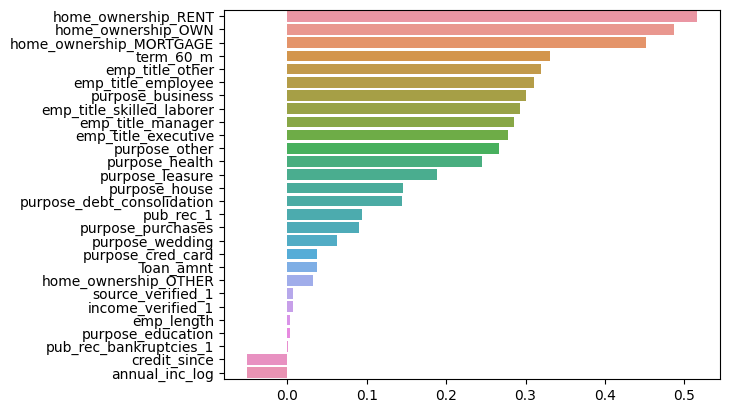

In [143]:
aa= coef_df.sort_values('Coefficients',ascending=False)[1:]
sns.barplot(x=aa.values.flatten(),y=aa.index)
plt.show()

### Gradient boosting

In [144]:
gbr_cl = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=300,
    random_state=random_seed 
)
# Model training
gbr_cl.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = gbr_cl.predict(X_train), gbr_cl.predict(X_test)
 

print(f'MSE: {round(mean_squared_error(y_test, y_pred_test),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_test)*100,2)} %')

print("Train R^2: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_pred_test)))

MSE: 0.09
MAPE: 10.03 %
Train R^2: 0.374
Test R^2: 0.314


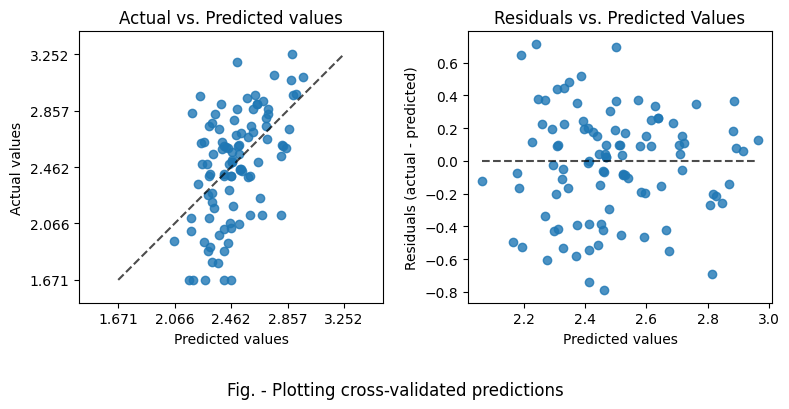

In [145]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

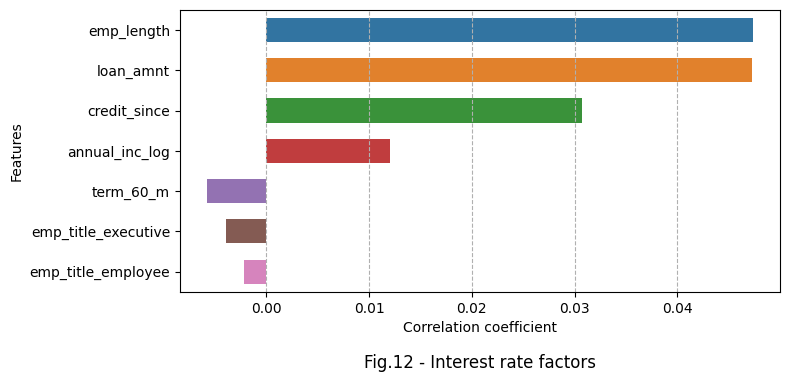

In [146]:
# correlation scores with the dependent variable
corr_df = X.corrwith(data['int_rate'], method='pearson')
corr_df = pd.DataFrame({'corr_value':corr_df}).iloc[:7]

corr_df.sort_values(by='corr_value', key=abs, ascending=False, inplace=True)#.round(2).to_dict()

plot_counter = 12
fig, ax = plt.subplots(figsize=(8, 4))
hist = sns.barplot(corr_df, x='corr_value' , y=corr_df.index, width=0.6);

hist.set(xlabel='Correlation coefficient', ylabel='Features')
ax.set_title(f'Fig.{plot_counter} - Interest rate factors', y=-0.3);
#major_ticks = np.linspace(-0.1, 0.1, 3)
#ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout()

plt.savefig(os.path.join(path_figures + f'fig_{plot_counter}.png'))

## Model comparison

In [147]:
# Save model to the given path in the pkl format
model_name = 'gbr_cl'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
#models_dict.update({'Revenue_CLoans':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gbr_cl, f)

In [148]:
data.head(1)

,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_log,source_verified,income_verified,credit_since
782893,25000.0,25000.0,25000.0,36_m,...,12.611538,1,1,20


In [149]:
corr_df.sort_values(by='corr_value', key=abs, ascending=False).index

Index(['emp_length', 'loan_amnt', 'credit_since', 'annual_inc_log',
       'term_60_m', 'emp_title_executive', 'emp_title_employee'],
      dtype='object')

# 4. Expected revenue estimation 

In [150]:
# current clients
data_c = current.copy() 

def dataset_preprocessing(data:pd.DataFrame)->pd.DataFrame:
    data = data[selected_cols]
    
    data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.date
    data['issued_year'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.year
    data['term'] = data['term'].replace({' 36 months': '36_m', ' 60 months': '60_m'})
    
    # employment length
    data['emp_length'] = data['emp_length'].apply(lambda x: str(x).replace('+ years', '')\
        .replace(' years', '').replace('< 1 year', '0')).replace('1 year', '1').replace('nan','-1').astype('int')
    data['emp_length'].replace(-1, 0, inplace=True)
    # professions
    data['emp_title'] = data['emp_title'].apply(str).str.strip()
    data['emp_title'] = data['emp_title'].apply(get_professions)
    
    # home ownership
    data['home_ownership'] = data['home_ownership'].apply(lambda x: x if x in ['MORTGAGE','RENT', 'OWN'] else 'OTHER').astype('category')
    
    
    # logarythm of the income
    data['annual_inc_log'] = data['annual_inc'].apply(lambda x: np.log(x) if x > 0  else 0)

    # binarization of the verrification status
    data['source_verified'] = data['verification_status'].apply(lambda x: 1 if x=='Source Verified' else 0).astype('category')
    data['income_verified'] = data['verification_status'].apply(lambda x: 1 if x==' Verified' or x=='Source Verified' else 0).astype('category')
    
    # purpose
    data['purpose'] = data['purpose'].apply(get_purpose)
    
    # bankruptcies
    data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 0 if x==0 else 1).astype('category')

    # credit history
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.date
    data['credit_since'] = data['issued_year'] - pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.year
    
    # Number of derogatory public records
    data['pub_rec'] = data['pub_rec'].apply(lambda x: 0 if x==0 else 1).astype('category')

    data.drop(['annual_inc', 'verification_status', 'installment'],axis=1, inplace=True) #'issue_d'
    
    return data #[selected_features]

data_c = dataset_preprocessing(data_c)
data_c = data_c[selected_features]
data_c.columns

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'emp_title', 'emp_length',
       'loan_status', 'home_ownership', 'annual_inc_log', 'purpose',
       'pub_rec_bankruptcies', 'credit_since', 'source_verified',
       'income_verified', 'pub_rec'],
      dtype='object')

In [151]:
data_c = data_c[selected_features]
print(data_c.shape)

temp = transformer.transform(data_c)

# apply all preprocessings
data_c = pd.DataFrame(temp, columns=transformer.transformers_[0][1].get_feature_names_out().tolist() + transformer.transformers_[1][1].get_feature_names_out().tolist())
print(data_c.shape)

(38550, 15)
(38550, 64)


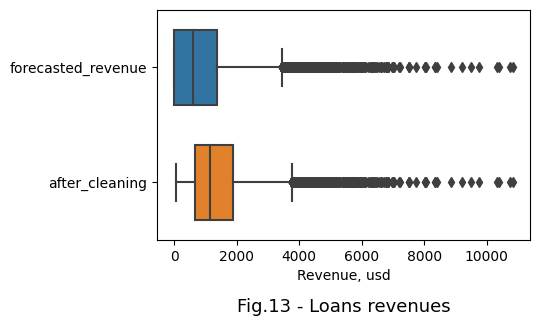

In [154]:
fig, ax = plt.subplots(1,1, figsize=(5.5, 3.5))
fig = sns.boxplot(data=result[['forecasted_revenue','after_cleaning']], orient='h',  width=.65)

plot_counter = 13
 
ax.set_xlabel('Revenue, usd')
#ax.set_ylabel('Scenario')
ax.set_title(f'Fig.{plot_counter} - Loans revenues', y=-0.35, fontsize=13) #, loc='right'
['Current', 'Proposed']
#ax.set_xscale('log')
 
#ax.set_xlim([0,200000])
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));